In [1]:
import numpy as np
np.random.seed(13)

import os
import shutil

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from time import sleep

from ipywidgets import IntProgress

import scipy
import librosa
import librosa.display

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
%matplotlib inline
matplotlib.style.use('ggplot')


from path import Path

from keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, Conv2D, MaxPool1D, MaxPooling2D, BatchNormalization, AveragePooling2D, GRU
from keras import callbacks

from keras import optimizers, regularizers
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

import cv2
import glob

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
"""
!pip install path.py

from google.colab import drive
drive.mount('/content/drive')
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "./UrbanSound8K/audio"
fold1 = os.path.join(data_path, "fold1")
fold2 = os.path.join(data_path, "fold2")
fold3 = os.path.join(data_path, "fold3")
fold4 = os.path.join(data_path, "fold4")
fold5 = os.path.join(data_path, "fold5")
fold6 = os.path.join(data_path, "fold6")
fold7 = os.path.join(data_path, "fold7")
fold8 = os.path.join(data_path, "fold8")
fold9 = os.path.join(data_path, "fold9")
fold10 = os.path.join(data_path, "fold10")

In [ ]:
data = pd.read_csv("./UrbanSound8K/metadata/UrbanSound8K.csv")
data['class'].value_counts(normalize=True)

children_playing    0.114521
dog_bark            0.114521
engine_idling       0.114521
street_music        0.114521
jackhammer          0.114521
drilling            0.114521
air_conditioner     0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: class, dtype: float64

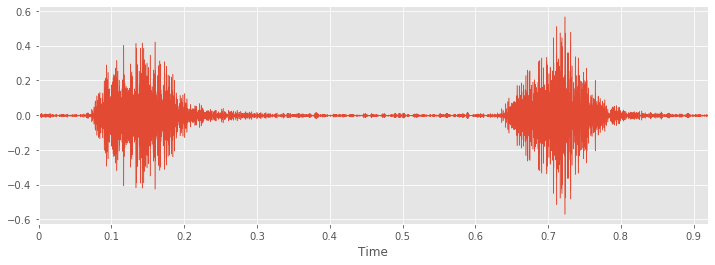

In [ ]:
file = os.path.join(data_path, 'fold8/4918-3-1-0.wav')
data,sample_rate = librosa.load(file)
plt.figure(figsize=(12,4))
librosa.display.waveplot(data,sr=sample_rate)

In [ ]:
import IPython.display as ipd
ipd.Audio(file)

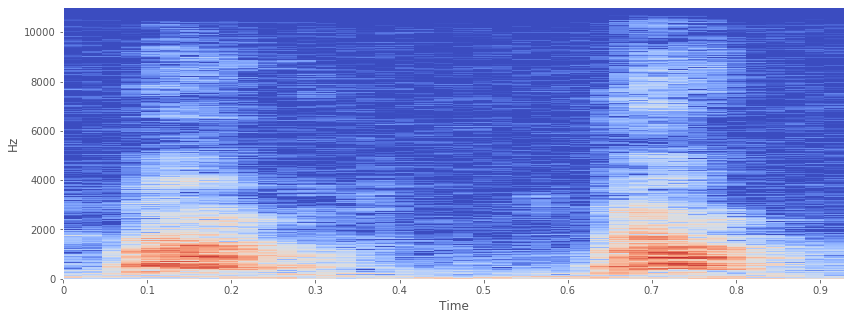

In [ ]:
x, sr = librosa.load(file)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

## Helper Functions

### Preprocessing

In [2]:
def assign_label(wav):
    label = float(wav[-1])
    return label

def mfccs_convert(path):
    dataX = []
    datay = []
    for i in range(1, 11):
        j = i
        i = str(i)
        X = []
        y = []
        filescount = 0
        print(j)
        for root, dirs, files in os.walk(path):
            dirs[:] = [d for d in dirs if d.endswith(i)]
            for wav in files:
                if wav.endswith(".wav"):
                    filescount += 1
        for root, dirs, files in os.walk(path):
            dirs[:] = [d for d in dirs if d.endswith(i)]
            for wav in tqdm(files, total = filescount, position=0, leave=True):
                if wav.endswith(".wav"):
                    p = os.path.join(root,wav)
                    label = assign_label(p.rsplit('-', 2)[0])
                    new, rate = librosa.load(p)
                    mfccs = np.mean(librosa.feature.mfcc(y = new, sr = rate, n_mfcc = 200).T, axis = 0)
                    y.append(label)
                    X.append(mfccs)
        dataX.append(X)
        datay.append(y)
    dataX = np.array(dataX)
    datay = np.array(datay)
    return dataX, datay

def fold_select(i, X, y):
    if i == 0:
        X_train = np.concatenate((np.array(X)[1:10]), axis=0)
        y_train = np.concatenate((np.array(y)[1:10]), axis=0)
    elif i == 9:
        X_train = np.concatenate((np.array(X)[0:9]), axis=0)
        y_train = np.concatenate((np.array(y)[0:9]), axis=0)
    else:
        X_l = np.concatenate((np.array(X)[0:i]), axis=0)
        X_r = np.concatenate((np.array(X)[i+1:10]), axis=0)
        y_l = np.concatenate((np.array(y)[0:i]), axis=0)
        y_r = np.concatenate((np.array(y)[i+1:10]), axis=0)
        X_train = np.concatenate((X_l, X_r), axis=0)
        y_train = np.concatenate((y_l, y_r), axis=0)
    X_test = np.array(X)[i]
    y_test = np.array(y)[i]
    return X_train, y_train, X_test, y_test

def create_fold_spectrograms(fold):
    spectrogram_path = Path('UrbanSound8K/spectrogram/')  
    audio_path = Path('UrbanSound8K/audio/')  
    print(f'Processing fold {fold}')
    os.mkdir(spectrogram_path/fold)
    for audio_file in list(Path(audio_path/f'fold{fold}').glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')
        
def image_fold_select(path, i, width, height):
    
    
    yTest = []

    spectrogram_path = Path(path)
    train_image = []
    test_image = []
    for file in os.listdir(os.path.join(spectrogram_path, str(i))):
        p = os.path.join(os.path.join(spectrogram_path, str(i), file))
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        #print(p)
        label = assign_label(p.rsplit('-', 2)[0])
        yTest.append(label)
        img = cv2.resize(img,(width, height),interpolation = cv2.INTER_AREA)
        test_image.append(img)
    X_test = np.array(test_image)
    y_test = np.array(yTest)
    
    y = []
    
    if i == 1:
        for j in tqdm(range(2,11)):
            for file in os.listdir(os.path.join(spectrogram_path, str(j))):
                p = os.path.join(os.path.join(spectrogram_path, str(j), file))
                img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
                #print(p)
                label = assign_label(p.rsplit('-', 2)[0])
                y.append(label)
                img = cv2.resize(img,(width, height),interpolation = cv2.INTER_AREA)
                train_image.append(img)
    elif i == 10:
        for j in tqdm(range(1,10)):
            for file in os.listdir(os.path.join(spectrogram_path, str(j))):
                p = os.path.join(os.path.join(spectrogram_path, str(j), file))
                img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
                #print(p)
                label = assign_label(p.rsplit('-', 2)[0])
                y.append(label)
                img = cv2.resize(img,(width, height),interpolation = cv2.INTER_AREA)
                train_image.append(img)
    else:
        for j in tqdm(range(1, i)):
            for file in os.listdir(os.path.join(spectrogram_path, str(j))):
                p = os.path.join(os.path.join(spectrogram_path, str(j), file))
                img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
                #print(p)
                label = assign_label(p.rsplit('-', 2)[0])
                y.append(label)
                img = cv2.resize(img,(width, height),interpolation = cv2.INTER_AREA)
                train_image.append(img)
        for j in tqdm(range(i+1, 11)):
            for file in os.listdir(os.path.join(spectrogram_path, str(j))):
                p = os.path.join(os.path.join(spectrogram_path, str(j), file))
                img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
                #print(p)
                label = assign_label(p.rsplit('-', 2)[0])
                y.append(label)
                img = cv2.resize(img,(width, height),interpolation = cv2.INTER_AREA)
                train_image.append(img) 
    X_train = np.array(train_image)
    y_test = np.array(y_test)
    y_train = np.array(y)
    return X_train, y_train, X_test, y_test

def conv1d_prepare(X):
    nrows, ncols = X.shape
    X = X.reshape(nrows, ncols, 1)
    return X

def balance_weight(x):
    class_weight = {0: 1.,
                1: 1.,
                2: 1.,
                3: 1.,
                4: 1.,
                5: 1.,
                6: 1.,
                7: 1.,
                8: x,
                9: x,}
    return class_weight

### Networks

In [ ]:
wd = './drive/My Drive/audio'

def ann_net(f):
    sc = StandardScaler()
    X1, y_train, X2, y_test = fold_select(f, Xt, yt)
    X_train = sc.fit_transform(X1)
    X_test = sc.fit_transform(X2)
    X_train.shape[1], X_train.shape[0], X_test.shape[0]

    print('processing fold', f+1)
     
    scores = pd.DataFrame(columns = ['Set', 'Fold', 'Score'])
    weight_decay = .0005
    num_classes = 10

    ann = models.Sequential()

    ann.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay), input_dim = X_train.shape[1]))
    ann.add(layers.Dropout(0.1))

    ann.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    ann.add(layers.Dropout(0.2))

    ann.add(layers.Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    ann.add(layers.Dropout(0.3))

    ann.add(layers.Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    ann.add(layers.Dropout(0.4))

    ann.add(layers.Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    ann.add(layers.Dropout(0.5))

    ann.add(layers.Dense(num_classes, activation = 'softmax'))

    ann.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    maxepochs = 50
    batch_size = 512

    checkpointer = callbacks.ModelCheckpoint(filepath = os.path.join(wd, 'ann.hdf5'),
                                             verbose = 0, save_best_only = True, monitor='val_acc')

    ann_history = ann.fit(X_train, y_train, batch_size = batch_size, epochs = maxepochs, 
                          validation_data = (X_test, y_test), class_weight = balance_weight(2), verbose = 0, callbacks=[checkpointer])
    
    ann.load_weights(os.path.join(wd, 'ann.hdf5'))
    
    score_list = [pd.Series(['Train' , f + 1, ann.evaluate(X_train, y_train, verbose=3)[1]], index = scores.columns),
                  pd.Series(['Test' , f + 1, ann.evaluate(X_test, y_test, verbose=3)[1]], index = scores.columns)]
    scores = scores.append(score_list , ignore_index=True)

    print ('fit to train : ', ann.evaluate(X_train, y_train, verbose=3)[1])
    print ('fit to test : ', ann.evaluate(X_test, y_test, verbose=3)[1])

    if f == 9:
        ann.summary()
    
    return scores


def cnn_1D(f):
    
    scores = pd.DataFrame(columns = ['Set', 'Fold', 'Score'])
    sc = StandardScaler()

    X1, y_train, X2, y_test = fold_select(f, Xt, yt)
    X_train = sc.fit_transform(X1)
    X_test = sc.fit_transform(X2)
    X_train = conv1d_prepare(X_train)
    X_test = conv1d_prepare(X_test)

    print('processing fold', f+1)

    
    weight_decay = .0005
    num_classes = 10
    input_shape = [X_train.shape[1], X_train.shape[2]]

    cnn_1d = models.Sequential()
    
    cnn_1d.add(layers.Conv1D(32, 5, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape = input_shape))
    cnn_1d.add(layers.Conv1D(32, 5, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_1d.add(layers.Dropout(0.1))

    cnn_1d.add(layers.Conv1D(64, 3, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_1d.add(layers.Conv1D(64, 3, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_1d.add(layers.MaxPooling1D(2))
    cnn_1d.add(layers.Dropout(0.1))

    cnn_1d.add(layers.Conv1D(128, 3, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_1d.add(layers.Conv1D(128, 3, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_1d.add(layers.MaxPooling1D(2))
    cnn_1d.add(layers.Dropout(0.1))

    cnn_1d.add(layers.Flatten())
           
    cnn_1d.add(layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_1d.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))

    cnn_1d.add(layers.Dense(num_classes, activation = 'softmax'))

    cnn_1d.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    maxepochs = 50
    batch_size = 1024

    checkpointer = callbacks.ModelCheckpoint(filepath = os.path.join(wd, 'cnn_1d.hdf5'),
                                             verbose = 0, save_best_only = True, monitor='val_acc')

    cnn_1d_history = cnn_1d.fit(X_train, y_train, batch_size = batch_size, epochs = maxepochs,
                                validation_data = (X_test, y_test), class_weight = balance_weight(2), verbose = 0, callbacks=[checkpointer])
    
    cnn_1d.load_weights(os.path.join(wd, 'cnn_1d.hdf5'))

    score_list = [pd.Series(['Train' , f + 1, cnn_1d.evaluate(X_train, y_train, verbose=3)[1]], index = scores.columns),
                  pd.Series(['Test' , f + 1, cnn_1d.evaluate(X_test, y_test, verbose=3)[1]], index = scores.columns)]
    scores = scores.append(score_list , ignore_index=True)

    print ('fit to train : ', cnn_1d.evaluate(X_train, y_train, verbose=3)[1])
    print ('fit to test : ', cnn_1d.evaluate(X_test, y_test, verbose=3)[1])

    if f == 9:
        cnn_1d.summary()
    
    return scores

def crnn_net(f):
    sc = StandardScaler()

    scores = pd.DataFrame(columns = ['Set', 'Fold', 'Score'])

    X1, y_train, X2, y_test = fold_select(f, Xt, yt)
    X_train = sc.fit_transform(X1)
    X_test = sc.fit_transform(X2)

    X_train = conv1d_prepare(X_train)
    X_test = conv1d_prepare(X_test)
    print('processing fold', f+1)
    weight_decay = .001
    num_classes = 10

    crnn = models.Sequential()
    
    crnn.add(layers.Conv1D(128, 5, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape = X_train.shape[1:]))
    crnn.add(layers.Conv1D(128, 5, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    crnn.add(layers.Dropout(0.5))

    crnn.add(layers.Conv1D(64, 3, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    crnn.add(layers.Conv1D(64, 3, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    crnn.add(layers.MaxPooling1D(2))
    crnn.add(layers.Dropout(0.4))

    crnn.add(layers.GRU(256, activation='tanh', kernel_regularizer = regularizers.l2(weight_decay)))

    crnn.add(layers.Dropout(0.5))

    crnn.add(layers.Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    crnn.add(layers.Dropout(0.5))
    crnn.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
    crnn.add(layers.Dropout(0.4))
    crnn.add(layers.Dense(num_classes, activation = 'softmax'))

    crnn.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    maxepochs = 150
    batch_size = 1024

    checkpointer = callbacks.ModelCheckpoint(filepath = os.path.join(wd, 'crnn.h5'),
                                             verbose = 0, save_best_only = True, monitor='val_acc')

    crnn_history = crnn.fit(X_train, y_train, batch_size = batch_size, epochs = maxepochs, 
                        validation_data = (X_test, y_test), class_weight = balance_weight(2), verbose = 0, callbacks = [checkpointer])
    
    crnn.load_weights(os.path.join(wd, 'crnn.h5'))
    
    score_list = [pd.Series(['Train' , f + 1, crnn.evaluate(X_train, y_train, verbose=3)[1]], index = scores.columns),
                  pd.Series(['Test' , f + 1, crnn.evaluate(X_test, y_test, verbose=3)[1]], index = scores.columns)]
    scores = scores.append(score_list , ignore_index=True)

    print ('fit to train : ', crnn.evaluate(X_train, y_train, verbose=3)[1])
    print ('fit to test : ', crnn.evaluate(X_test, y_test, verbose=3)[1])

    if f == 9:
        crnn.summary()

    return scores


def cnn_2D(f):

    scores = pd.DataFrame(columns = ['Set', 'Fold', 'Score'])

    img_path = os.path.join(wd, 'img_arrays')
    wt_path = os.path.join(wd, 'cnn_weights')
    data = np.load(os.path.join(img_path, str(f), 'data.npz'))
    X_train, y_train, X_test, y_test = data['X_train'], data['y_train'], data['X_test'], data['y_test']

    print('processing fold', f+1)

    num_classes = 10
    weight_decay = 0.00005
    x_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3]]

    cnn_2d = models.Sequential()

    cnn_2d.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_2d.add(layers.MaxPooling2D((2, 2)))
    cnn_2d.add(layers.Dropout(0.2))

    cnn_2d.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_2d.add(layers.MaxPooling2D((2, 2)))
    cnn_2d.add(layers.Dropout(0.3))

    cnn_2d.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_2d.add(layers.MaxPooling2D((2, 2)))
    cnn_2d.add(layers.Dropout(0.4))

    cnn_2d.add(layers.Conv2D(256, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_2d.add(layers.MaxPooling2D((2, 2)))
    cnn_2d.add(layers.Dropout(0.5))

    cnn_2d.add(layers.Flatten())
    cnn_2d.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    cnn_2d.add(layers.Dropout(0.5))
    cnn_2d.add(layers.Dense(num_classes, activation='softmax'))


    cnn_2d.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    if os.path.exists(os.path.join(wt_path, str(f), 'cnn_2d.hdf5')):
        cnn_2d.load_weights(os.path.join(wt_path, str(f), 'cnn_2d.hdf5'))

    else:

        maxepochs = 150
        batch_size = 256

        checkpointer = callbacks.ModelCheckpoint(filepath = os.path.join(wt_path, str(f), 'cnn_2d.hdf5'), 
                                                 verbose = 0, save_best_only = True, monitor='val_acc')
    
        cnn_2d_history = cnn_2d.fit(X_train, y_train, batch_size = batch_size, epochs = maxepochs,
                                    validation_data = (X_test, y_test), class_weight = balance_weight(2), callbacks = [checkpointer], verbose = 0)
    
        cnn_2d.load_weights(os.path.join(wt_path, str(f), 'cnn_2d.hdf5'))

    score_list = [pd.Series(['Train' , f + 1, cnn_2d.evaluate(X_train, y_train, verbose=3)[1]], index = scores.columns),
                  pd.Series(['Test' , f + 1, cnn_2d.evaluate(X_test, y_test, verbose=3)[1]], index = scores.columns)]
    scores = scores.append(score_list , ignore_index=True)

    print ('fit to train : ', cnn_2d.evaluate(X_train, y_train, verbose=3)[1])
    print ('fit to test : ', cnn_2d.evaluate(X_test, y_test, verbose=3)[1])

    if f == 9:
        cnn_2d.summary()

    return scores

## Convert to images

In [ ]:
process2img = False
if process2img == True:
    for i in range(1, 11):
        create_fold_spectrograms(str(i))

## Compute the MFCC (Mel Frequency Cepstral Coefficients) from the raw audio

In [3]:
#path = 'drive/My Drive/audio'
path = './'
if os.path.exists(os.path.join(path, 'Xt.npy')):
    Xt = np.load(os.path.join(path, 'Xt.npy'), allow_pickle=True)
    yt = np.load(os.path.join(path, 'yt.npy'), allow_pickle=True)
else:
    Xt, yt = mfccs_convert(data_path)
    np.save('Xt.npy', Xt)
    np.save('yt.npy', yt)

## Classic Algorithms

In [ ]:
Xt.shape, yt.shape

((10,), (10,))

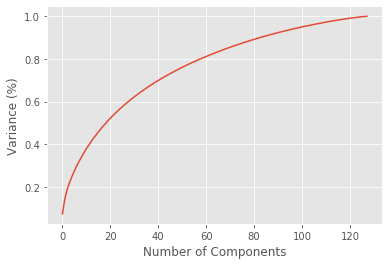

In [ ]:
sc = StandardScaler()
X_train, y_train, X_test, y_test = fold_select(8, Xt, yt)
x_train_scaled = sc.fit_transform(X_train)
x_test_scaled = sc.fit_transform(X_test)

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

### Random Forest

In [ ]:
parameters = {
    'n_estimators'      : [300, 500, 1000],
    'max_depth'         : [None, 15, 25],
    'min_samples_leaf' : [1, 10, 20, 30],
    'criterion' :['gini','entropy']
}
sc = StandardScaler()
X1, y_train, X2, y_test = fold_select(9, Xt, yt)
X_train = sc.fit_transform(X1)
X_test = sc.fit_transform(X2)

cv_clf = GridSearchCV(RandomForestClassifier(), parameters, cv = 9, n_jobs = 6, verbose = 2)
cv_clf.fit(X_train, y_train)
print(cv_clf.score(X_test, y_test))
print(cv_clf.best_params_)

In [4]:
sc = StandardScaler()
clf_rf = RandomForestClassifier(n_estimators = 300, max_depth = 15, min_samples_leaf = 1, criterion = 'entropy', n_jobs =6)
Random_Forest_scores = []

for i in range(10):
    X1, y_train, X2, y_test = fold_select(8, Xt, yt)
    X_train = sc.fit_transform(X1)
    X_test = sc.fit_transform(X2)
    clf_rf.fit(X_train, y_train)
    Random_Forest_scores.append(['Train', i+1,  clf_rf.score(X_train, y_train)])
    Random_Forest_scores.append(['Test', i+1,  clf_rf.score(X_test, y_test)])
    print ('fit to train : ', clf_rf.score(X_train, y_train))
    print ('fit to test : ', clf_rf.score(X_test, y_test))

fit to train :  0.9998736735725113
fit to test :  0.6703431372549019
fit to train :  0.9997473471450228
fit to test :  0.6507352941176471
fit to train :  0.9998736735725113
fit to test :  0.6642156862745098
fit to train :  0.9997473471450228
fit to test :  0.6715686274509803
fit to train :  0.9996210207175341
fit to test :  0.6691176470588235
fit to train :  0.9998736735725113
fit to test :  0.6642156862745098
fit to train :  0.9996210207175341
fit to test :  0.6642156862745098
fit to train :  0.9994946942900454
fit to test :  0.6727941176470589
fit to train :  0.9997473471450228
fit to test :  0.6740196078431373
fit to train :  0.9997473471450228
fit to test :  0.6678921568627451


In [5]:
Random_Forest_scores = pd.DataFrame(Random_Forest_scores, columns = ['set', 'fold', 'accuracy'])
mean_acc_rf = Random_Forest_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].mean(axis = 0)
st_dev_rf = Random_Forest_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].std(axis = 0)
Random_Forest_scores, mean_acc_rf, st_dev_rf

(      set  fold  accuracy
 0   Train     1  0.999874
 1    Test     1  0.670343
 2   Train     2  0.999747
 3    Test     2  0.650735
 4   Train     3  0.999874
 5    Test     3  0.664216
 6   Train     4  0.999747
 7    Test     4  0.671569
 8   Train     5  0.999621
 9    Test     5  0.669118
 10  Train     6  0.999874
 11   Test     6  0.664216
 12  Train     7  0.999621
 13   Test     7  0.664216
 14  Train     8  0.999495
 15   Test     8  0.672794
 16  Train     9  0.999747
 17   Test     9  0.674020
 18  Train    10  0.999747
 19   Test    10  0.667892, accuracy    0.666912
 dtype: float64, accuracy    0.006732
 dtype: float64)

In [6]:
Random_Forest_scores.to_csv('Random_Forest_scores.csv', index=False, header=True)

### Logistic regression

In [ ]:
parameters = {'C':  [1, 10, 100],
              'penalty': ['l2'],
             'multi_class' : ['multinomial', 'ovr'],
             'solver' : ['lbfgs', 'newton-cg']}

X1, y_train, X2, y_test = fold_select(9, Xt, yt)
X_train = sc.fit_transform(X1)
X_test = sc.fit_transform(X2)
cv_clf_lr = GridSearchCV(LogisticRegression(), parameters, cv = 9, n_jobs = 6, verbose = 2)

cv_clf_lr.fit(X_train, y_train)
print(cv_clf_lr.score(X_test, y_test))
print(cv_clf_lr.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   20.6s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:  1.7min finished


0.4432497013142174
{'C': 100, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}


In [7]:
Log_reg_scores = []
for i in range(10):
    X1, y_train, X2, y_test = fold_select(i, Xt, yt)
    X_train = sc.fit_transform(X1)
    X_test = sc.fit_transform(X2)
    clf_lr = LogisticRegression(C = 100, multi_class = 'ovr', penalty = 'l2', solver = 'lbfgs', n_jobs = 6, verbose = 2)
    clf_lr.fit(X_train, y_train)
    Log_reg_scores.append(['Train', i+1,  clf_lr.score(X_train, y_train)])
    Log_reg_scores.append(['Test', i+1,  clf_lr.score(X_test, y_test)])

    print ('fit to train : ', clf_lr.score(X_train, y_train))
    print ('fit to test : ', clf_lr.score(X_test, y_test))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.1s finished


fit to train :  0.7493319760783814
fit to test :  0.48109965635738833


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.9s finished


fit to train :  0.7488526262111168
fit to test :  0.4369369369369369


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.0s finished


fit to train :  0.7504803381580633
fit to test :  0.4540540540540541


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.0s finished


fit to train :  0.7375355205373288
fit to test :  0.5444444444444444


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.1s finished


fit to train :  0.7419189327860441
fit to test :  0.5801282051282052


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.1s finished


fit to train :  0.7525603742571754
fit to test :  0.37667071688942894


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.0s finished


fit to train :  0.7395490245756271
fit to test :  0.5023866348448688


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.0s finished


fit to train :  0.7419883926318446
fit to test :  0.5632754342431762


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.0s finished


fit to train :  0.7410308236483072
fit to test :  0.5894607843137255


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    1.6s remaining:    1.6s


fit to train :  0.7413552881570614
fit to test :  0.4432497013142174


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.0s finished


In [8]:
Log_reg_scores = pd.DataFrame(Log_reg_scores, columns = ['set', 'fold', 'accuracy'])
mean_acc_logreg = Log_reg_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].mean(axis = 0)
st_dev_logreg = Log_reg_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].std(axis = 0)
Log_reg_scores, mean_acc_logreg, st_dev_logreg

(      set  fold  accuracy
 0   Train     1  0.749332
 1    Test     1  0.481100
 2   Train     2  0.748853
 3    Test     2  0.436937
 4   Train     3  0.750480
 5    Test     3  0.454054
 6   Train     4  0.737536
 7    Test     4  0.544444
 8   Train     5  0.741919
 9    Test     5  0.580128
 10  Train     6  0.752560
 11   Test     6  0.376671
 12  Train     7  0.739549
 13   Test     7  0.502387
 14  Train     8  0.741988
 15   Test     8  0.563275
 16  Train     9  0.741031
 17   Test     9  0.589461
 18  Train    10  0.741355
 19   Test    10  0.443250, accuracy    0.497171
 dtype: float64, accuracy    0.070871
 dtype: float64)

In [9]:
Log_reg_scores.to_csv('Log_reg_scores.csv', index=False, header=True)

### K-NN

In [ ]:
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'leaf_size' : [10, 30, 50, 100]
}
X1, y_train, X2, y_test = fold_select(9, Xt, yt)
X_train = sc.fit_transform(X1)
X_test = sc.fit_transform(X2)

clf_cv_knn = GridSearchCV(KNeighborsClassifier(), parameters, cv=9, n_jobs=6, verbose = 2)
clf_cv_knn.fit(X_train, y_train)

print(clf_cv_knn.score(X_test, y_test))
print(clf_cv_knn.best_params_)

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   27.3s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 1001 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 1446 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 1973 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 2560 out of 2560 | elapsed: 19.9min finished


0.3847072879330944
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [10]:
knn_scores = []
clf_knn = KNeighborsClassifier(n_neighbors = 3, weights = 'distance', metric = 'euclidean', leaf_size = 10, algorithm = 'auto', n_jobs = 6)
for i in range(10):
    X1, y_train, X2, y_test = fold_select(i, Xt, yt)
    X_train = sc.fit_transform(X1)
    X_test = sc.fit_transform(X2)
    clf_knn.fit(X_train, y_train)
    knn_scores.append(['Train', i+1,  clf_knn.score(X_train, y_train)])
    knn_scores.append(['Test', i+1,  clf_knn.score(X_test, y_test)])

    print ('fit to train : ', clf_knn.score(X_train, y_train))
    print ('fit to test : ', clf_knn.score(X_test, y_test))

fit to train :  1.0
fit to test :  0.36769759450171824
fit to train :  1.0
fit to test :  0.40653153153153154
fit to train :  1.0
fit to test :  0.38594594594594595
fit to train :  1.0
fit to test :  0.36666666666666664
fit to train :  1.0
fit to test :  0.4326923076923077
fit to train :  1.0
fit to test :  0.36938031591737547
fit to train :  1.0
fit to test :  0.43675417661097854
fit to train :  1.0
fit to test :  0.36228287841191065
fit to train :  1.0
fit to test :  0.49142156862745096
fit to train :  1.0
fit to test :  0.3847072879330944


In [11]:
knn_scores = pd.DataFrame(knn_scores, columns = ['set', 'fold', 'accuracy'])
mean_acc_knn = knn_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].mean(axis = 0)
st_dev_knn = knn_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].std(axis = 0)
knn_scores, mean_acc_knn, st_dev_knn

(      set  fold  accuracy
 0   Train     1  1.000000
 1    Test     1  0.367698
 2   Train     2  1.000000
 3    Test     2  0.406532
 4   Train     3  1.000000
 5    Test     3  0.385946
 6   Train     4  1.000000
 7    Test     4  0.366667
 8   Train     5  1.000000
 9    Test     5  0.432692
 10  Train     6  1.000000
 11   Test     6  0.369380
 12  Train     7  1.000000
 13   Test     7  0.436754
 14  Train     8  1.000000
 15   Test     8  0.362283
 16  Train     9  1.000000
 17   Test     9  0.491422
 18  Train    10  1.000000
 19   Test    10  0.384707, accuracy    0.400408
 dtype: float64, accuracy    0.041852
 dtype: float64)

In [12]:
knn_scores.to_csv('knn_scores.csv', index=False, header=True)

### SVM

In [ ]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':(1,0.25,0.5,0.75),'gamma': (1, 3,'auto'),'decision_function_shape':('ovo','ovr')}

X1, y_train, X2, y_test = fold_select(9, Xt, yt)
X_train = sc.fit_transform(X1)
X_test = sc.fit_transform(X2)

clf_cv_svc = GridSearchCV(svm, parameters, cv=9, n_jobs=6, verbose = 2)
clf_cv_svc.fit(X_train, y_train)

print(clf_cv_svc.score(X_test, y_test))
print(clf_cv_svc.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed: 26.1min
[Parallel(n_jobs=6)]: Done 480 out of 480 | elapsed: 37.1min finished


0.5746714456391876
{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'}


In [13]:
svc_scores = []
clf_svm = SVC(C = 1, kernel = 'rbf', decision_function_shape = 'ovo', gamma = 'auto')
for i in range(10):
    X1, y_train, X2, y_test = fold_select(i, Xt, yt)
    X_train = sc.fit_transform(X1)
    X_test = sc.fit_transform(X2)
    clf_svm.fit(X_train, y_train)
    svc_scores.append(['Train', i+1,  clf_svm.score(X_train, y_train)])
    svc_scores.append(['Test', i+1,  clf_svm.score(X_test, y_test)])

    print ('fit to train : ', clf_svm.score(X_train, y_train))
    print ('fit to test : ', clf_svm.score(X_test, y_test))

fit to train :  0.9442677185392544
fit to test :  0.563573883161512
fit to train :  0.9422488526262112
fit to test :  0.5056306306306306
fit to train :  0.946202126296913
fit to test :  0.5027027027027027
fit to train :  0.9430379746835443
fit to test :  0.5787878787878787
fit to train :  0.9415084658799384
fit to test :  0.6581196581196581
fit to train :  0.942217726640536
fit to test :  0.4993924665856622
fit to train :  0.9429946795034203
fit to test :  0.581145584725537
fit to train :  0.9441079989906637
fit to test :  0.5992555831265509
fit to train :  0.9432794340576048
fit to test :  0.6764705882352942
fit to train :  0.9386953768207726
fit to test :  0.5746714456391876


In [14]:
svc_scores = pd.DataFrame(svc_scores, columns = ['set', 'fold', 'accuracy'])
mean_acc_svc = svc_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].mean(axis = 0)
st_dev_svc = svc_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].std(axis = 0)
svc_scores, mean_acc_svc, st_dev_svc

(      set  fold  accuracy
 0   Train     1  0.944268
 1    Test     1  0.563574
 2   Train     2  0.942249
 3    Test     2  0.505631
 4   Train     3  0.946202
 5    Test     3  0.502703
 6   Train     4  0.943038
 7    Test     4  0.578788
 8   Train     5  0.941508
 9    Test     5  0.658120
 10  Train     6  0.942218
 11   Test     6  0.499392
 12  Train     7  0.942995
 13   Test     7  0.581146
 14  Train     8  0.944108
 15   Test     8  0.599256
 16  Train     9  0.943279
 17   Test     9  0.676471
 18  Train    10  0.938695
 19   Test    10  0.574671, accuracy    0.573975
 dtype: float64, accuracy    0.061211
 dtype: float64)

In [15]:
svc_scores.to_csv('svc_scores.csv', index=False, header=True)

## ANN

In [25]:
ann_scores = pd.DataFrame(columns = ['Set', 'Fold', 'Score'])
for i in range(10):
    scores = ann_net(i)
    ann_scores = ann_scores.append(scores, ignore_index=True)

processing fold 1
fit to train :  0.8583789285789512
fit to test :  0.5864833908119289
processing fold 2
fit to train :  0.9255481896991331
fit to test :  0.5292792787423005
processing fold 3
fit to train :  0.988856154732932
fit to test :  0.5189189186289503
processing fold 4
fit to train :  0.9882459312839059
fit to test :  0.6010101006488607
processing fold 5
fit to train :  0.9763981528683403
fit to test :  0.6185897435897436
processing fold 6
fit to train :  0.9893791882665318
fit to test :  0.4969623328558874
processing fold 7
fit to train :  0.9899923992906005
fit to test :  0.6408114559895098
processing fold 8
fit to train :  0.9451173354272074
fit to test :  0.6215880893300249
processing fold 9
fit to train :  0.9839565437089439
fit to test :  0.6948529411764706
processing fold 10
fit to train :  0.9887270424621176
fit to test :  0.5854241338824429
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape

In [ ]:
mean_acc_ann = ann_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].mean(axis = 0)
st_dev_ann = ann_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].std(axis = 0)

In [27]:
ann_scores.to_csv(os.path.join(path, 'ann_scores.csv'), index=False, header=True)
ann_scores, mean_acc_ann, st_dev_ann

(      Set Fold     Score
 0   Train    1  0.858379
 1    Test    1  0.586483
 2   Train    2  0.925548
 3    Test    2  0.529279
 4   Train    3  0.988856
 5    Test    3  0.518919
 6   Train    4  0.988246
 7    Test    4  0.601010
 8   Train    5  0.976398
 9    Test    5  0.618590
 10  Train    6  0.989379
 11   Test    6  0.496962
 12  Train    7  0.989992
 13   Test    7  0.640811
 14  Train    8  0.945117
 15   Test    8  0.621588
 16  Train    9  0.983957
 17   Test    9  0.694853
 18  Train   10  0.988727
 19   Test   10  0.585424, Score    0.589392
 dtype: float64, Score    0.060496
 dtype: float64)

## Conv 1D

In [31]:
cnn_1d_scores = pd.DataFrame(columns = ['Set', 'Fold', 'Score'])
for i in range(10):
    scores = cnn_1D(i)
    cnn_1d_scores = cnn_1d_scores.append(scores, ignore_index=True)

processing fold 1
fit to train :  0.9454129024579759
fit to test :  0.4650630011625443
processing fold 2
fit to train :  0.8230494645588985
fit to test :  0.5990990990990991
processing fold 3
fit to train :  0.833610861947629
fit to test :  0.5286486478753992
processing fold 4
fit to train :  0.9102299147661082
fit to test :  0.5636363633955368
processing fold 5
fit to train :  0.995382247306311
fit to test :  0.5865384615384616
processing fold 6
fit to train :  0.9447464913389809
fit to test :  0.4945321991261126
processing fold 7
fit to train :  0.9271598682090666
fit to test :  0.5453460619102515
processing fold 8
fit to train :  0.9647993944733846
fit to test :  0.5769230770709792
processing fold 9
fit to train :  0.9744820616472966
fit to test :  0.6323529411764706
processing fold 10
fit to train :  0.9861937935402153
fit to test :  0.5519713263072991
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape 

In [ ]:
mean_acc_cnn_1d = cnn_1d_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].mean(axis = 0)
st_dev_cnn_1d = cnn_1d_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].std(axis = 0)

In [33]:
cnn_1d_scores.to_csv(os.path.join(path, 'cnn_1d_scores.csv'), index=False, header=True)
cnn_1d_scores, mean_acc_cnn_1d, st_dev_cnn_1d

(      Set Fold     Score
 0   Train    1  0.945413
 1    Test    1  0.465063
 2   Train    2  0.823049
 3    Test    2  0.599099
 4   Train    3  0.833611
 5    Test    3  0.528649
 6   Train    4  0.910230
 7    Test    4  0.563636
 8   Train    5  0.995382
 9    Test    5  0.586538
 10  Train    6  0.944746
 11   Test    6  0.494532
 12  Train    7  0.927160
 13   Test    7  0.545346
 14  Train    8  0.964799
 15   Test    8  0.576923
 16  Train    9  0.974482
 17   Test    9  0.632353
 18  Train   10  0.986194
 19   Test   10  0.551971, Score    0.554411
 dtype: float64, Score    0.04946
 dtype: float64)

## CRNN

In [10]:
crnn_scores = pd.DataFrame(columns = ['Set', 'Fold', 'Score'])
for i in range(10):
    scores = crnn_net(i)
    crnn_scores = crnn_scores.append(scores, ignore_index=True)

processing fold 1
fit to train :  0.90469525390218
fit to test :  0.5658648341791737
processing fold 2
fit to train :  0.8545385007649159
fit to test :  0.588963963963964
processing fold 3
fit to train :  0.8842064813628795
fit to test :  0.5189189188544815
processing fold 4
fit to train :  0.7191940066242243
fit to test :  0.5444444445046511
processing fold 5
fit to train :  0.889430477106614
fit to test :  0.6068376068376068
processing fold 6
fit to train :  0.9049184473384752
fit to test :  0.503037667252748
processing fold 7
fit to train :  0.8661008360327301
fit to test :  0.6181384246787479
processing fold 8
fit to train :  0.8550340651773968
fit to test :  0.5868486353836344
processing fold 9
fit to train :  0.8941384537645275
fit to test :  0.6495098039215687
processing fold 10
fit to train :  0.8975300823607877
fit to test :  0.6583034648975021
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape    

In [ ]:
mean_acc_crnn = crnn_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].mean(axis = 0)
st_dev_crnn = crnn_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].std(axis = 0)

In [12]:
crnn_scores.to_csv(os.path.join(path, 'crnn_scores.csv'), index=False, header=True)
crnn_scores, mean_acc_crnn, st_dev_crnn

(      Set Fold     Score
 0   Train    1  0.904695
 1    Test    1  0.565865
 2   Train    2  0.854539
 3    Test    2  0.588964
 4   Train    3  0.884206
 5    Test    3  0.518919
 6   Train    4  0.719194
 7    Test    4  0.544444
 8   Train    5  0.889430
 9    Test    5  0.606838
 10  Train    6  0.904918
 11   Test    6  0.503038
 12  Train    7  0.866101
 13   Test    7  0.618138
 14  Train    8  0.855034
 15   Test    8  0.586849
 16  Train    9  0.894138
 17   Test    9  0.649510
 18  Train   10  0.897530
 19   Test   10  0.658303, Score    0.584087
 dtype: float64, Score    0.051872
 dtype: float64)

## Conv 2D

### Image Data preparation

In [ ]:
dim = 64
X_train, y_train, X_test, y_test = image_fold_select(data_path, 9, dim, dim)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], dim, dim, 1)
X_test = X_test.reshape(X_test.shape[0], dim, dim, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.
X_test /= 255.

In [153]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7859, 64, 64, 1), (873, 64, 64, 1), (7859,), (873,))

In [ ]:
#np.savez('img_arrays/0/data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [236]:
"""
cnn_2d.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
cnn_2d.add(layers.MaxPooling2D((2, 2)))
cnn_2d.add(layers.Dropout(0.2))

cnn_2d.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
cnn_2d.add(layers.MaxPooling2D((2, 2)))
cnn_2d.add(layers.Dropout(0.3))

cnn_2d.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
cnn_2d.add(layers.MaxPooling2D((2, 2)))
cnn_2d.add(layers.Dropout(0.4))

cnn_2d.add(layers.Conv2D(256, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
cnn_2d.add(layers.MaxPooling2D((2, 2)))
cnn_2d.add(layers.Dropout(0.5))

cnn_2d.add(layers.Flatten())
cnn_2d.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
cnn_2d.add(layers.Dropout(0.5))
cnn_2d.add(layers.Dense(num_classes, activation='softmax'))
"""

"\ncnn_2d.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)))\ncnn_2d.add(layers.MaxPooling2D((2, 2)))\ncnn_2d.add(layers.Dropout(0.2))\n\ncnn_2d.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))\ncnn_2d.add(layers.MaxPooling2D((2, 2)))\ncnn_2d.add(layers.Dropout(0.3))\n\ncnn_2d.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))\ncnn_2d.add(layers.MaxPooling2D((2, 2)))\ncnn_2d.add(layers.Dropout(0.4))\n\ncnn_2d.add(layers.Conv2D(256, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))\ncnn_2d.add(layers.MaxPooling2D((2, 2)))\ncnn_2d.add(layers.Dropout(0.5))\n\ncnn_2d.add(layers.Flatten())\ncnn_2d.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))\ncnn_2d.add(layers.Dropout(0.5))\ncnn_2d.add(layers.Dense(num_classes, activation='softmax'))\n"

### Execution

In [30]:
cnn_2d_scores = pd.DataFrame(columns = ['Set', 'Fold', 'Score'])
for i in range(10):
    scores = cnn_2D(i)
    cnn_2d_scores = cnn_2d_scores.append(scores, ignore_index=True)

processing fold 1
fit to train :  0.9189464308056975
fit to test :  0.742268041305389
processing fold 2
fit to train :  0.9906935237123916
fit to test :  0.7398648654018436
processing fold 3
fit to train :  0.9832201868971346
fit to test :  0.6886486494863355
processing fold 4
fit to train :  0.9959958667011108
fit to test :  0.694949495551562
processing fold 5
fit to train :  0.9962801436634171
fit to test :  0.7660256410256411
processing fold 6
fit to train :  0.99266658237451
fit to test :  0.7095990272223008
processing fold 7
fit to train :  0.8910564985612328
fit to test :  0.702863961956097
processing fold 8
fit to train :  0.9962149886449659
fit to test :  0.7096774195027411
processing fold 9
fit to train :  0.9973471450227388
fit to test :  0.7977941176470589
processing fold 10
fit to train :  0.9934135528815706
fit to test :  0.7491039426523297
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape    

In [ ]:
mean_acc_cnn_2d = cnn_2d_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].mean(axis = 0)
st_dev_cnn_2d = cnn_2d_scores.iloc[[1, 3, 5, 7, 9, 11, 13, 15, 17, 19], [2]].std(axis = 0)

In [32]:
cnn_2d_scores.to_csv(os.path.join(path, 'cnn_2d_scores.csv'), index=False, header=True)
cnn_2d_scores, mean_acc_cnn_2d, st_dev_cnn_2d

(      Set Fold     Score
 0   Train    1  0.918946
 1    Test    1  0.742268
 2   Train    2  0.990694
 3    Test    2  0.739865
 4   Train    3  0.983220
 5    Test    3  0.688649
 6   Train    4  0.995996
 7    Test    4  0.694949
 8   Train    5  0.996280
 9    Test    5  0.766026
 10  Train    6  0.992667
 11   Test    6  0.709599
 12  Train    7  0.891056
 13   Test    7  0.702864
 14  Train    8  0.996215
 15   Test    8  0.709677
 16  Train    9  0.997347
 17   Test    9  0.797794
 18  Train   10  0.993414
 19   Test   10  0.749104, Score    0.73008
 dtype: float64, Score    0.034977
 dtype: float64)